In [6]:
%matplotlib inline
import sys
from collections import defaultdict, Counter
import networkx as nx
import numpy as np
import pylab as plt
import math
from itertools import chain
#import matplotlib.cm as cm
import statsmodels.api as sm
from os import listdir
from scipy.stats.stats import pearsonr
import json
import random
import itertools
from copy import deepcopy
import time
import scipy as sp
from scipy.sparse import csr_matrix
from scipy.stats import entropy
import matplotlib.cm as cm
from numpy.random import choice
import itertools
from sklearn import manifold
import operator
import itertools
from datetime import datetime as dt
import matplotlib.mlab as mlab
from scipy.stats import norm
import re
from scipy import stats
from scipy.spatial import Voronoi
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats.mstats import zscore
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles

## Granger Test requires two time series

### Load Time Series 1 - Jobs
2010-2016 Data Science Data Engineering Burning Glass DataSet (see PNAS paper for more info)


In [1]:

J={}
with open('time_series1.txt','r', encoding ='latin') as f:
    for line in f:
        line=line.strip()
        skill=line.split('[')[0].strip().lower() # extract skill
        vs=line.split('[')[1].split(']')[0].split(',') # vector : extract years + frequency - all content split by commas
        dic=dict((int(i.split(':')[0]),int(i.split(':')[1])) for i in vs) # split year and freq
        # KEY is skill, VALUE is year, freq 
        J[skill]=dic


### Load Time Series 2 - Publication
2010-2016 Web of Science IU dataset - Data Science and Data Engineering subset

In [2]:
W={}   # only skills that are matched to skills in DSDE Jobs
with open('time_series2.txt','r', encoding = 'latin') as f:
    for line in f:
        line=line.strip()
        skill=line.split('[')[0].strip().lower() # extract skill
        if skill in J:
            vs=line.split('[')[1].split(']')[0].split(',') # vector : extract years + frequency - all content split by commas
            dic=dict((int(i.split(':')[0]),int(i.split(':')[1])) for i in vs) # split year and freq
            W[skill]=dic



### Data Transformation and Alignment
two time series must be of the same size and the same keys (elements)

In [8]:
#JOBS
JW={}
for i in J:

    if i in W.keys():
        JW[i] = J[i]


In [9]:
### Add non-zero values
for key, value in JW.items():

    for i in JW[key]:
        if JW[key][i]==0:
            JW[key][i]=0.00001


In [10]:
#3.  split J by year and find total per year
## JOB DATA TRANSFORMATION USE JW
JT=defaultdict(int) # initializing first dictionary for collection/list
for i in JW:
    for year in JW[i]:
        JT[year]+=JW[i][year]

JN={}
for i in JW:
    dic=dict((k,v/float(JT[k])) for k,v in JW[i].items() if 2010<=k<=2016 and v!=0)#if 2010<=k<=2016 and v!=0 ) 

    if len(dic)==7:
        JN[i]=dic

In [11]:
## PUBS - Addd non-zero values
for key, value in W.items():

    for i in W[key]:
        if W[key][i]==0:
            W[key][i]=0.00001

In [12]:
#  WOS data transformation
WT=defaultdict(int)
for i in W:
    for year in W[i]:
        WT[year]+=W[i][year]
WN={}
for i in W:
    dic=dict((k,v/float(WT[k])) for k,v in W[i].items() if 2010<=k<=2016)# and v!=0)
    if len(dic)==7:
        WN[i]=dic

In [13]:
len(JN), len(WN)

(2376, 2376)

### Granger Calculation

In [15]:
years=range(2010,2017) # start 2010, up to excluding 2017
ts={}
gs={}

In [16]:
# GRANGER CAUSALITY FORMULA
#s - skills
# WN dictionary (skill {year: frequency, year2: frequency})
#years 2010-2016
# Create a dictionary to store S, x1 WOS, x2 JOBS
for s in list(WN.keys()):

    if s in JN:
        x1=[WN[s][i] for i in years]
        x2=[JN[s][i] for i in years]
        ts[s]=[x1,x2]
 
        rs1=grangercausalitytests(list(zip(x1, x2)),1, verbose=False) ### INDUSTRY precedes Acadaemia added list for python 3
        rs2=grangercausalitytests(list(zip(x2,x1)),1,verbose = False)  # Academie to INDUSTRY change to tRUE to see causality info
        f_Ind2Aca=rs1[1][0]['params_ftest'][0]
        p_Ind2Aca=rs1[1][0]['params_ftest'][1]

        beta_Ind2Aca=rs1[1][1][1].params[1]   # to do

        f_Aca2Ind=rs2[1][0]['params_ftest'][0]
        p_Aca2Ind=rs2[1][0]['params_ftest'][1]
        beta_Aca2Ind=rs2[1][1][1].params[1] # Academia to Industry 

        lrt_Ind2Aca = rs1[1][0]['lrtest'][1]
        lrt_Aca2Ind = rs2[1][0]['lrtest'][1]

        gs[s]=[beta_Ind2Aca,f_Ind2Aca,p_Ind2Aca,lrt_Ind2Aca,beta_Aca2Ind,f_Aca2Ind,p_Aca2Ind,lrt_Aca2Ind]  # beta1, F1, beta2, F2

# ({'ssr_ftest': (11.205867668505235, 0.18480451282753935, 1.0, 1), 
#'ssr_chi2test': (44.823470674020939, 2.1562254925768266e-11, 1), 
#'lrtest': (10.007667170206375, 0.0015588986043359847, 1), 
#'params_ftest': (11.205867668505167, 0.18480451282753985, 1.0, 1)},


In [17]:
beta_Ind2Aca,f_Ind2Aca,p_Ind2Aca,lrt_Ind2Aca,beta_Aca2Ind,f_Aca2Ind,p_Aca2Ind,lrt_Aca2Ind=np.array(list(gs.values())).T # The T attribute is the transpose of 
#the array. Add list in python 3

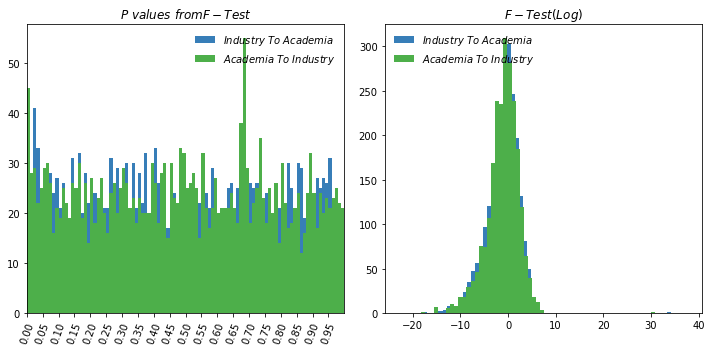

In [19]:
fig = plt.figure(figsize=(10, 5),facecolor='white')

ax = fig.add_subplot(121)
plt.hist(p_Ind2Aca,100,label=r'$Industry\ To\ Academia$',color='#377eb8')
plt.hist(p_Aca2Ind,100,label=r'$Academia\ To\ Industry$',color='#4daf4a')
plt.title(r'$P\ values\ from F-Test$')
plt.xlim(0,1)
plt.xticks(np.arange(0, 1, 0.05),rotation=70)
#plt.xlim(-200,200)
plt.legend(loc=1,fontsize=10,frameon=False)
ax = fig.add_subplot(122)
plt.hist(np.log2(f_Ind2Aca), 70,label=r'$Industry\ To\ Academia$', color='#377eb8') # number of bins
plt.hist(np.log2(f_Aca2Ind), 70,label=r'$Academia\ To\ Industry$',color='#4daf4a') # number of bins
plt.title(r'$F-Test (Log)$')
plt.legend(loc=2,fontsize=10,frameon=False)
#plt.savefig('granger-P-F-histograms.png')
plt.tight_layout()

## Extract Significant Values

In [21]:
#Extract significant p-Values
IndAca = {}
AcaInd = {}
for i in gs:
    g = gs[i]
    if g[2] < 0.05:
        IndAca[i] = g
    if g[6] < 0.05:
        AcaInd[i] = g
     

### Intersect of Granger between two time series
how many overlapping events show granger significance in boths sets

In [30]:
# find 10 skills that intersect and their F values
for i in IndAca:
    if i in AcaInd:           
        print(i + '\t' + str(IndAca[i][1]) + '\t'+ str(AcaInd[i][5]))

allele	49.2729121393	16.9175220557
angularjs	179.371616165	79.7375397616
chef	18.7768823344	22.2475347276
computational tools	10.9552803033	15.3367821155
linkage analysis	17.3247357388	13.8606915632
product knowledge	13.3409358262	16.9368117803
rsx	19.9009696407	11.7683551033
solar photovoltaic design	81.8773122923	71.8572202382
transcription	15.8515047247	1924.05151096
trial design	52.6159857524	34.0386676002


In [21]:
# Save ALL F and p-values into a text files (rename file if needed)
file1 = open("F-test-WOS-JOBS.txt", "w")
file1.write('skill' + '\t' + 'FIndAca' + '\t' + 'pIndAca' + '\t' + 'FAcaInd' + '\t' + 'pAcaInd' + '\n')
for i in gs:
    file1.write(str(i) + '\t' + str(gs[i][1]) +'\t' + str(gs[i][2]) + '\t' + str(gs[i][5]) + '\t' + str(gs[i][6]) +'\n')
file1.close()